In [18]:
import os
import matplotlib.pyplot as plt

import torch
import tensorkrowch as tk

In [19]:
torch.set_num_threads(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eps = 1e-10

cwd = os.getcwd()

In [20]:
# Define Slater functions
# =======================

def slater(x, L, m, d):
    """
    Returns the output of the m-dimensional Slater function with input in the
    domain [0, L]^m.

    Parameters
    ----------
    x : torch.Tensor
        Tensor of binary inputs with shape batch x (d*m).
    L : int, float
        Limit of domain.
    m : int
        Number of dimensions/variables
    d : int
        Discretization level of each variable.
    """
    # assert len(x.shape) == 2
    assert x.size(1) == d*m
    
    x = x.reshape(-1, d, m)
    
    total_x = torch.zeros_like(x)[:, 0, :].float()  # batch x m
    for i in range(1, d + 1):
        total_x += x[:, i - 1, :] * 2 ** (-i)
    
    total_x = total_x * L  # total_x in [0, L]^m
    
    norm_x = total_x.norm(p=2, dim=1)
    result = (-norm_x).exp() / (norm_x + eps)
    
    return result

In [21]:
L = 10.
m = 1
d = 50
bond_dim = 10
samples_size = 1000
sketch_size = 100

n_features = m*d

cores_rss_dir = os.path.join(
    cwd, '..', '..', 'results', '1_performance', 'slater_functions',
    f'rss_{L}_{m}_{d}_{bond_dim}_{samples_size}_{sketch_size}')
cores_rss_dir = os.path.join(cores_rss_dir, os.listdir(cores_rss_dir)[0])

cores_cross_dir = os.path.join(
    cwd, '..', '..', 'results', '1_performance', 'slater_functions',
    f'cross_{L}_{m}_{d}_{bond_dim}_{samples_size}')
cores_cross_dir = os.path.join(cores_cross_dir, os.listdir(cores_cross_dir)[0])

def discretize(x):
    return tk.embeddings.discretize(x, level=d).reshape(-1, d*m).int()

def embedding(x): return tk.embeddings.basis(x, dim=2).float()

cores_rss = torch.load(cores_rss_dir, weights_only=False)
mps_rss = tk.models.MPS(tensors=[c.to(device) for c in cores_rss])
mps_rss.parameterize(set_param=False, override=True)
mps_rss.trace(torch.zeros(1, n_features, 2, device=device),
              inline_input=True,
              inline_mats=True)

cores_cross = torch.load(cores_cross_dir, weights_only=False)
mps_cross = tk.models.MPS(tensors=[c.to(device) for c in cores_cross])
mps_cross.parameterize(set_param=False, override=True)
mps_cross.trace(torch.zeros(1, n_features, 2, device=device),
                inline_input=True,
                inline_mats=True)

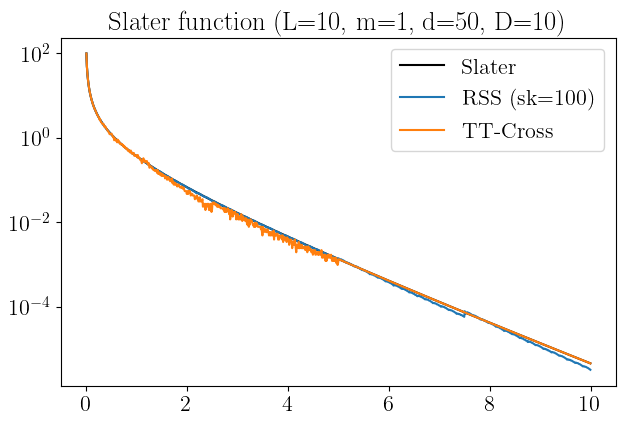

In [22]:
# plt.rc('font', family='serif', size=15)
plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)

colormap = plt.get_cmap("tab10")
color = colormap(0)

fig = plt.figure(figsize=(6.5, 4.5))

n_points = 1000

aux_eps = 1e-3
samples = torch.linspace(aux_eps, 1-aux_eps, n_points).to(device)
bin_samples = discretize(samples)

slater_results = slater(x=bin_samples, L=L, m=m, d=d)
rss_results = mps_rss(embedding(bin_samples),
                      inline_input=True,
                      inline_mats=True)
cross_results = mps_cross(embedding(bin_samples),
                          inline_input=True,
                          inline_mats=True)

plt.plot(L * samples.cpu(), slater_results.cpu(), label='Slater', color='black')
plt.plot(L * samples.cpu(), rss_results.cpu(), label='RSS (sk=100)', color='tab:blue')
plt.plot(L * samples.cpu(), cross_results.cpu(), label='TT-Cross', color='tab:orange')

plt.yscale('log')
plt.legend()
plt.title('Slater function (L=10, m=1, d=50, D=10)')

plt.tight_layout(pad=1.)

results_dir = os.path.join(cwd, '..', '..', 'results', '1_performance', 'slater_functions')
plt.savefig(os.path.join(results_dir, 'slater_1D.pdf'), bbox_inches='tight')

plt.show()

In [13]:
rss_diffs = (slater_results - rss_results).abs()
print('Max:', rss_diffs.max())
print('Min:', rss_diffs.min())
print('Mean:', rss_diffs.mean())
print('Median:', rss_diffs.median())
print('Norm-1:', rss_diffs.norm(p=1))
print('Norm-2:', rss_diffs.norm(p=2))
print('Norm-inf:', rss_diffs.norm(p=float('inf')))

Max: tensor(0.9384, device='cuda:0')
Min: tensor(5.2038e-08, device='cuda:0')
Mean: tensor(0.0032, device='cuda:0')
Median: tensor(2.9949e-05, device='cuda:0')
Norm-1: tensor(3.2449, device='cuda:0')
Norm-2: tensor(1.3301, device='cuda:0')
Norm-inf: tensor(0.9384, device='cuda:0')


In [14]:
cross_diffs = (slater_results - cross_results).abs()
print('Max:', cross_diffs.max())
print('Min:', cross_diffs.min())
print('Mean:', cross_diffs.mean())
print('Median:', cross_diffs.median())
print('Norm-1:', cross_diffs.norm(p=1))
print('Norm-2:', cross_diffs.norm(p=2))
print('Norm-inf:', cross_diffs.norm(p=float('inf')))

Max: tensor(0.1466, device='cuda:0')
Min: tensor(0., device='cuda:0')
Mean: tensor(0.0065, device='cuda:0')
Median: tensor(9.5461e-09, device='cuda:0')
Norm-1: tensor(6.4603, device='cuda:0')
Norm-2: tensor(0.5705, device='cuda:0')
Norm-inf: tensor(0.1466, device='cuda:0')


In [15]:
# RSS
L = 10.
m = 3
# d = 50
bond_dim = 16
samples_size = 1000
sketch_size = 100

for d in range(10, 22, 2):
    times = []
    sketch_accs = []
    rel_accs = []

    cores_rss_dir = os.path.join(
        cwd, '..', '..', 'results', '1_performance', 'slater_functions',
        f'rss_{L}_{m}_{d}_{bond_dim}_{samples_size}_{sketch_size}')
    
    for f in os.listdir(cores_rss_dir):
        parts_f = f.split('_')
        parts_f[-1] = parts_f[-1][:-3]
        
        times.append(float(parts_f[0]))
        sketch_accs.append(float(parts_f[1]))
        rel_accs.append(float(parts_f[2]))

    times = torch.Tensor(times)
    sketch_accs = torch.Tensor(sketch_accs)
    rel_accs = torch.Tensor(rel_accs)

    print(f'{d=}')
    print('----')
    print(f'Time: {times.mean():.2e}')
    print(f'Sketch Acc.: {sketch_accs.mean():.2e}')
    print(f'Mean Rel. Acc.: {rel_accs.mean():.2e}')
    print(f'Std Rel. Acc.: {rel_accs.std():.2e}')
    print(f'Median Rel. Acc.: {rel_accs.median():.2e}')
    print()

d=10
----
Time: 5.78e+00
Sketch Acc.: 1.19e-04
Mean Rel. Acc.: 1.10e-01
Std Rel. Acc.: 2.35e-01
Median Rel. Acc.: 3.17e-02

d=12
----
Time: 7.22e+00
Sketch Acc.: 1.17e-04
Mean Rel. Acc.: 9.58e-02
Std Rel. Acc.: 2.18e-01
Median Rel. Acc.: 2.05e-02

d=14
----
Time: 8.82e+00
Sketch Acc.: 1.49e-04
Mean Rel. Acc.: 3.86e-01
Std Rel. Acc.: 9.83e-01
Median Rel. Acc.: 2.72e-02

d=16
----
Time: 1.09e+01
Sketch Acc.: 1.68e-04
Mean Rel. Acc.: 1.88e-01
Std Rel. Acc.: 5.99e-01
Median Rel. Acc.: 2.97e-02

d=18
----
Time: 1.29e+01
Sketch Acc.: 1.24e-04
Mean Rel. Acc.: 9.22e-02
Std Rel. Acc.: 2.13e-01
Median Rel. Acc.: 2.74e-02

d=20
----
Time: 1.47e+01
Sketch Acc.: 1.35e-04
Mean Rel. Acc.: 1.72e-01
Std Rel. Acc.: 3.61e-01
Median Rel. Acc.: 3.08e-02



In [16]:
# Cross
L = 10.
m = 3
# d = 50
bond_dim = 16
samples_size = 1000
sketch_size = 100

for d in range(10, 22, 2):
    times = []
    rel_accs = []

    cores_cross_dir = os.path.join(
        cwd, '..', '..', 'results', '1_performance', 'slater_functions',
        f'cross_{L}_{m}_{d}_{bond_dim}_{samples_size}')
    
    for f in os.listdir(cores_cross_dir):
        parts_f = f.split('_')
        parts_f[-1] = parts_f[-1][:-3]
        
        times.append(float(parts_f[0]))
        rel_accs.append(float(parts_f[1]))

    times = torch.Tensor(times)
    rel_accs = torch.Tensor(rel_accs)

    print(f'{d=}')
    print('----')
    print(f'Time: {times.mean():.2e}')
    print(f'Mean Rel. Acc.: {rel_accs.mean():.2e}')
    print(f'Std Rel. Acc.: {rel_accs.std():.2e}')
    print(f'Median Rel. Acc.: {rel_accs.median():.2e}')
    print()

d=10
----
Time: 1.35e+02
Mean Rel. Acc.: 6.26e-03
Std Rel. Acc.: 2.55e-03
Median Rel. Acc.: 5.83e-03

d=12
----
Time: 2.04e+02
Mean Rel. Acc.: 9.49e-03
Std Rel. Acc.: 2.40e-03
Median Rel. Acc.: 9.17e-03

d=14
----
Time: 2.82e+02
Mean Rel. Acc.: 8.10e-03
Std Rel. Acc.: 3.55e-03
Median Rel. Acc.: 7.01e-03

d=16
----
Time: 3.62e+02
Mean Rel. Acc.: 1.26e-02
Std Rel. Acc.: 3.76e-03
Median Rel. Acc.: 1.20e-02

d=18
----
Time: 4.22e+02
Mean Rel. Acc.: 2.03e-02
Std Rel. Acc.: 8.74e-03
Median Rel. Acc.: 1.94e-02

d=20
----
Time: 4.62e+02
Mean Rel. Acc.: 4.59e-02
Std Rel. Acc.: 2.23e-02
Median Rel. Acc.: 4.62e-02

